In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Resize

from tqdm import tqdm
import imageio
import gc

#from sklearn.model_selection import train_test_split

In [27]:
from ResNet import some_model

In [28]:
cfg = dict()
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 1 # 11
cfg['dropout'] = 0.2
cfg['fc_intermediate_len'] = 100 # ? 128
cfg['x_size'] = 150 # ? such order of dims
cfg['y_size'] = 300 # ? such order of dims

In [29]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [30]:
# only Carbon counts
class PretrainRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file, y_file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        self.y = torch.tensor(np.load(y_file)[:,1], dtype=torch.float32).unsqueeze(1)
        self.y.to(device)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        y = self.y[index]
        return pic, y

# For training

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
device

device(type='cuda')

In [7]:
def calc_loss(cnn, data_loader, loss_type='mse'):
    if loss_type =='mse': 
        Loss = nn.MSELoss()
    elif loss_type == 'mae':
        Loss = nn.L1Loss(reduction='sum')
    else:
        return 'ERROR'

    loss = 0.0
    count = 0
    cnn.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = cnn(x_batch)
            loss += Loss(predictions, y_batch).item()
            count += y_batch.shape[0] * y_batch.shape[1]
    return loss / count

In [8]:
def train_epoch(data_loader, cnn, optimizer, criterion):
    running_loss = 0.0
    for x_batch, y_batch in tqdm(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss

In [9]:
def train_model(dataset_train, dataset_test, cnn, n_epochs, batch_size, history):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=10, persistent_workers=True,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2,pin_memory=False)

    #criterion = nn.MSELoss()
    #criterion = nn.L1Loss()
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_loss = train_epoch(data_train_loader, cnn, optimizer, criterion)
        
        print('Train running loss (L1Smooth):\t', train_loss)
        train_loss = calc_loss(cnn, data_train_loader, 'mae')
        test_loss  = calc_loss(cnn, data_test_loader,  'mae')
        print('Train loss (MAE):\t', test_loss)
        print('Test  loss (MAE):\t', test_loss)
        history.append((train_loss, test_loss))

## Pre-training on small dataset.

In [18]:
"""
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train.csv',
                                          'data/pretrain2/atom_counts_train.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test.csv',
                                          'data/pretrain2/atom_counts_test.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])
"""
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train_small.csv',
                                          'data/pretrain2/atom_counts_train_small.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test_small.csv',
                                          'data/pretrain2/atom_counts_test_small.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])

In [25]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
resnet = some_model(1, 1)

In [22]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [26]:
%%time
train_model(dataset_train, dataset_test, resnet, n_epochs=5, batch_size=25)

  0%|          | 0/320 [00:00<?, ?it/s]

Starting epoch 0


  0%|          | 0/320 [00:00<?, ?it/s]

Train running loss (L1Smooth):	 694.50158816576
Test loss (MAE):			 2.8286894969940186
Starting epoch 1


  0%|          | 0/320 [00:00<?, ?it/s]

Train running loss (L1Smooth):	 413.459808409214
Test loss (MAE):			 2.3172939224243163
Starting epoch 2


  0%|          | 0/320 [00:00<?, ?it/s]

Train running loss (L1Smooth):	 353.17281755805016
Test loss (MAE):			 1.2502723779678344
Starting epoch 3


  0%|          | 0/320 [00:00<?, ?it/s]

Train running loss (L1Smooth):	 322.9752231836319
Test loss (MAE):			 2.100978073120117
Starting epoch 4


100%|██████████| 320/320 [01:51<00:00,  2.86it/s]


Train running loss (L1Smooth):	 302.7650328576565
Test loss (MAE):			 1.162437092781067
CPU times: user 7min 33s, sys: 2min 30s, total: 10min 4s
Wall time: 10min 1s


In [27]:
preds = []
trues = []
resnet.eval()
for index, (_, __) in enumerate(dataset_test):
    if index > 5:
        break
    with torch.no_grad():
        pred = resnet(_.unsqueeze(0).to(device)).item()
    preds.append(pred)
    trues.append(__.item())
        
print(*preds)
print(*trues)

11.559694290161133 18.008541107177734 20.980161666870117 10.457900047302246 19.475666046142578 15.549481391906738
13.0 19.0 21.0 11.0 21.0 16.0


In [28]:
torch.save(resnet.state_dict(), 'data/resnet_v1.model')

## Intermediate results

The chosen model seems to learn quite well with:
- small dataset
- SmoothL1Loss
- Adam, lr=0.001

## Real training
Now we add history saving parameter to the training procedure and start several epochs with a larger dataset, and smaller learning_rate for several epochs.

In [10]:
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train_medium.csv',
                                          'data/pretrain2/atom_counts_train_medium.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test_medium.csv',
                                          'data/pretrain2/atom_counts_test_medium.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])

In [11]:
resnet = some_model(1, 1)
resnet.load_state_dict(torch.load('data/resnet_v1.model'))
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [13]:
history = []

In [15]:
%%time
train_model(dataset_train, dataset_test, resnet, n_epochs=15, batch_size=25, history=history)

  0%|          | 0/3200 [00:00<?, ?it/s]

Starting epoch 0


100%|██████████| 3200/3200 [18:44<00:00,  2.84it/s]


Train running loss (L1Smooth):	 2241.2227632179856


  0%|          | 0/3200 [00:00<?, ?it/s]

Train loss (MAE):	 1.148617372226715
Test  loss (MAE):	 1.148617372226715
Starting epoch 1


100%|██████████| 3200/3200 [18:48<00:00,  2.84it/s]


Train running loss (L1Smooth):	 983.1178817395121


  0%|          | 0/3200 [00:00<?, ?it/s]

Train loss (MAE):	 0.4584425177574158
Test  loss (MAE):	 0.4584425177574158
Starting epoch 2


100%|██████████| 3200/3200 [19:02<00:00,  2.80it/s]


Train running loss (L1Smooth):	 673.4267708789557


  0%|          | 0/3200 [00:00<?, ?it/s]

Train loss (MAE):	 0.37884814946651457
Test  loss (MAE):	 0.37884814946651457
Starting epoch 3


100%|██████████| 3200/3200 [18:56<00:00,  2.82it/s]


Train running loss (L1Smooth):	 528.9946883115917


  0%|          | 0/3200 [00:00<?, ?it/s]

Train loss (MAE):	 0.3671844476222992
Test  loss (MAE):	 0.3671844476222992
Starting epoch 4


 15%|█▌        | 495/3200 [02:52<15:44,  2.86it/s]


KeyboardInterrupt: 

Interrupted kernel since training takes a lot of time and the loss on validation seems to be acceptable.

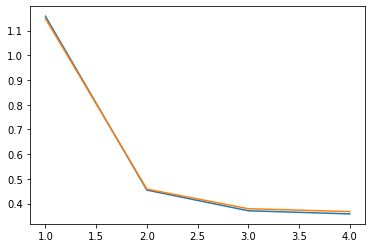

In [16]:
hist = np.zeros((len(history), 2))
for i, elem in enumerate(history):
    hist[i][0] = elem[0]
    hist[i][1] = elem[1]
x = np.arange(1,1+len(history))
plt.plot(x, hist[:,0])
plt.plot(x, hist[:,1])
plt.show()

In [17]:
history

[(1.1581490986824035, 1.148617372226715),
 (0.45430765943527224, 0.4584425177574158),
 (0.3706275754392147, 0.37884814946651457),
 (0.35784649117588996, 0.3671844476222992)]

In [22]:
preds = np.zeros(10)
trues = []
resnet.eval()
for index, (_, __) in enumerate(dataset_test):
    if index > 9:
        break
    with torch.no_grad():
        pred = resnet(_.unsqueeze(0).to(device)).item()
    preds[index] = pred
    trues.append(__.item())
        
print(*np.round(preds, 2), sep='\t')
print(*trues, sep='\t')

22.18	12.82	34.2	16.62	13.14	25.61	8.71	27.66	21.87	9.14
20.0	13.0	33.0	17.0	13.0	26.0	9.0	28.0	22.0	9.0


In [23]:
torch.save(resnet.state_dict(), 'data/resnet_C.model')

## Calculating C counts for test dataset.

In [6]:
class TestPicturesDataset(torch.utils.data.Dataset):
    def __init__(self, file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index], is_train=False).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        return pic

In [17]:
dataset_test = TestPicturesDataset('submissions/random_from_train.csv')

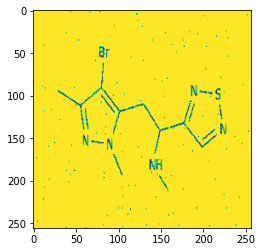

In [18]:
for pic in dataset_test:
    plt.imshow(pic[0])
    break

In [19]:
b_size = 25
test_loader = torch.utils.data.DataLoader(dataset_test, b_size, num_workers=10, 
                                          persistent_workers=True, pin_memory=True)

In [11]:
resnet = some_model(1, 1)
resnet.load_state_dict(torch.load('data/resnet_C.model'))
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [20]:
results = np.zeros(len(dataset_test), dtype=np.int32)
results.shape

(1616107,)

In [25]:
resnet.eval()
with torch.no_grad():
    index = 0
    for x_batch in tqdm(test_loader):
        preds = resnet(x_batch.to(device))
        results[index:(index+x_batch.shape[0])] = np.round(preds.to(torch.device('cpu')
                                                                   ).numpy()[:,0]).astype(np.int32)
        index += x_batch.shape[0]

print(results.shape)
results

  8%|▊         | 5122/64645 [13:26<2:36:14,  6.35it/s]


KeyboardInterrupt: 

Works too long, so transferred it to a Kaggle kernel for computations.